<a href="https://colab.research.google.com/github/Rayonil/Interpolating_PBLH/blob/main/Interpolating_PBLH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Conectar Drive e Importar Bibliotecas**

## Conectar ao Driver

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Instalar bibliotecas

In [2]:
!pip install netCDF4 -q
!pip install rasterio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 39.7 MB/s eta 0:00:00


##Importar as Bibliotecas




In [3]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from platform import python_version
from math import pi, cos
import os, time, argparse, platform, subprocess
from rich.progress import Progress
import glob
from tqdm import tqdm

# **1. Calcular e Plotar Mapas da PBLH_ERA5**

## 1.1. Calcular a Média da PBLH diurna

Dentro do diretório base encontra-se os dados horários da PBLH de 2020 provenientes do ERA5.

Neste exemplo apenas o período diurno está sendo calculado para verificar a média da fase convectiva da camada limite.

In [12]:
# Diretório onde estão os arquivos
diretorio_base = os.listdir('~/PBLH_2020')
diretorio_base.sort()

Criar uma lista vazia onde os dataframes de cada hora serão armazenados

In [18]:
# Lista para armazenar os DataFrames
lista_de_dataframes = []

In [19]:
# Loop para ler os arquivos dentro do diretorio_base
for arquivo in diretorio_base:
  # Lendo o arquivo e criando o DataFrame
  df = pd.read_csv('/content/drive/MyDrive/Mapas_Amazonia/PBLH/Anual/PBLH_2020/{}'.format(arquivo),
                    delimiter='\t')

  lista_de_arquivos.append(df)

# Concatenando os DataFrames ao longo das colunas e calculando a média da coluna PBLH
media_pblh = pd.concat([df['PBLH'] for df in lista_de_arquivos], axis=1).mean(axis=1)

# Criando um novo DataFrame com a média da coluna PBLH
df_media_pblh = pd.DataFrame({
    'latitude': lista_de_arquivos[0]['latitude'],  # Supondo que a coluna 'latitude' seja a mesma em todos os dataframes
    'longitude': lista_de_arquivos[0]['longitude'],  # Supondo que a coluna 'longitude' seja a mesma em todos os dataframes
    'PBLH_media': media_pblh
})

Foi criado um dataframe com a média do ano de 2020.

In [20]:
df_media_pblh.head()

,latitude,longitude,PBLH_media
0,7.00,-75.0,754.681111
1,6.75,-75.0,854.595556
2,6.50,-75.0,842.962222
3,6.25,-75.0,769.596667
4,6.00,-75.0,805.087222


## **1.2. Plotar a PBLH espacializada para a Amazônia**

### Lendo os dados e filtar os pontos dentro do shape da Amazônia

In [21]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Lendo o shapefile da Amazônia
amazonia_shapefile = "/content/drive/MyDrive/Mapas_Amazonia/Shape_AM/Bioma_Amazonico.shp"  # Substitua pelo caminho real para o seu shapefile
amazonia = gpd.read_file(amazonia_shapefile)


# Criando uma lista de objetos Point com base nas latitudes e longitudes
geometry = [Point(lon, lat) for lon, lat in zip(df_media_pblh['longitude'], df_media_pblh['latitude'])]

# Criando um GeoDataFrame a partir dos pontos
gdf_pontos = gpd.GeoDataFrame(df_media_pblh, geometry=geometry, crs=amazonia.crs)

# Filtrando apenas os pontos que estão dentro do shape da Amazônia
pontos_amazonia = gdf_pontos[gdf_pontos.within(amazonia.geometry.unary_union)]

### Interpolar os dados e Criar o Polygonos

In [22]:
from shapely.geometry import Polygon
from scipy.interpolate import griddata
# Resolução da grade
resolucao = 0.1

# Calculando os limites da grade a partir dos limites da Amazônia
xmin, ymin, xmax, ymax = amazonia.total_bounds
xgrid = np.arange(xmin, xmax, resolucao)
ygrid = np.arange(ymin, ymax, resolucao)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)

# Criando polígonos a partir dos pontos interpolados
poligonos_interpolados = [Polygon([(x, y), (x + resolucao, y), (x + resolucao, y + resolucao), (x, y + resolucao)])
                          for x, y in zip(xgrid.flat, ygrid.flat)]

# Criando um GeoDataFrame com os polígonos interpolados
gdf_interpolado = gpd.GeoDataFrame(geometry=poligonos_interpolados, crs=amazonia.crs)

# Interpolando os valores de PBLH para os polígonos
gdf_interpolado['PBLH'] = griddata((pontos_amazonia['longitude'], pontos_amazonia['latitude']),
                                   pontos_amazonia['PBLH_media'], (xgrid, ygrid), method='cubic').flatten()

# Fazendo a interseção com o shapefile da Amazônia
resultado_final = gpd.overlay(gdf_interpolado, amazonia, how='intersection')


### Plotar o Mapa da PBLH na Amazônia

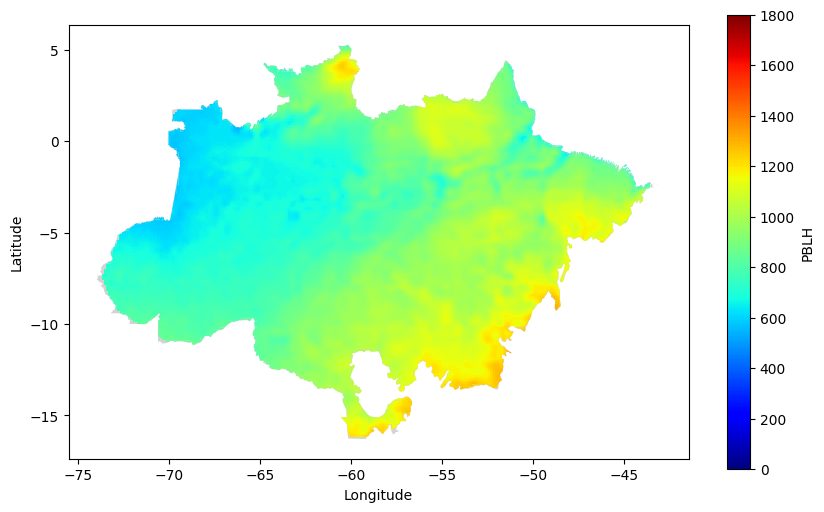

In [23]:
# Criando o mapa com base no GeoDataFrame resultante
fig, ax = plt.subplots(figsize=(10, 10))
amazonia.plot(ax=ax, color='lightgrey')  # Plotando o contorno da Amazônia em cinza claro

# Plotando o PBLH interpolado dentro dos limites da Amazônia
resultado_final.plot(column='PBLH', cmap='jet', ax=ax,  vmin=0, vmax=1800)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Adicionando a barra de cores manualmente
sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1800))
sm._A = []  # Criando uma lista vazia para armazenar os valores da barra de cores
cbar = plt.colorbar(sm, ax=ax, shrink=0.59) # Definindo o tamanho da barra de cores
cbar.set_label('PBLH')

# Definir a pasta de saída
saida = r'/content/drive/MyDrive/'
# Criar uma nova pasta Plots usando a função os.makedirs()
sub_dir = os.path.join(saida, 'Plot_PBLH/')
arquivo = 'PBLH_2020'
if not os.path.exists(sub_dir):
  os.makedirs(sub_dir)
plt.savefig(sub_dir + arquivo , dpi=400)
plt.show()